# Recreate Kernel Ridge Regression from ATSML

Recreates the KRR example done in ATSML, but in Python instead of R. Idea is to have some true function which we know (in reality we don't) and generate data from this function, perturbing it with noise. The function is non-linear, ridge regression is linear, but using a kernel allows for linear models to capture non-linear behavious by projecting the data into a higher dimension where it is linear via the kernel trick with a feature mapping.

We vary the hyperparameters gamma (inverse bandwith in RBF kernel i.e. sigma) and alpha (regularization parameter in ridge regression i.e. lambda), then use a grid search cv to optimize both. Original R code in ATSML folder.

In [86]:
#simulate data for a krr. model is some y = function + noise
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings as wrns
wrns.filterwarnings('ignore')
def funct(x):
    f = x - 1.2*x**2 - 0.8*x**3 + 0.6*np.cos(2*np.pi*x)
    return f

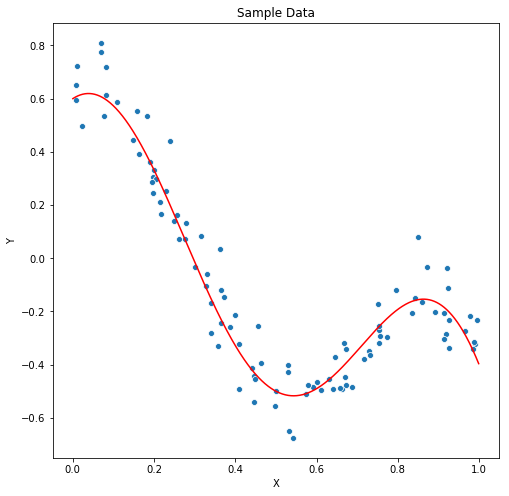

In [87]:
#noise normally distributed, then create matrix of data
sig = 0.1
n = 100
x = np.random.uniform(0,1,n)
y = funct(x) + np.random.normal(0,sig,n)

#vars for exact line
x_exact = np.arange(0,1,.001)
y_exact = funct(x_exact)

#plot
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.scatterplot(x, y)
sns.lineplot(x_exact, y_exact, color = 'r')
ax.set(xlabel = "X",ylabel = "Y",title = "Sample Data")
plt.show()

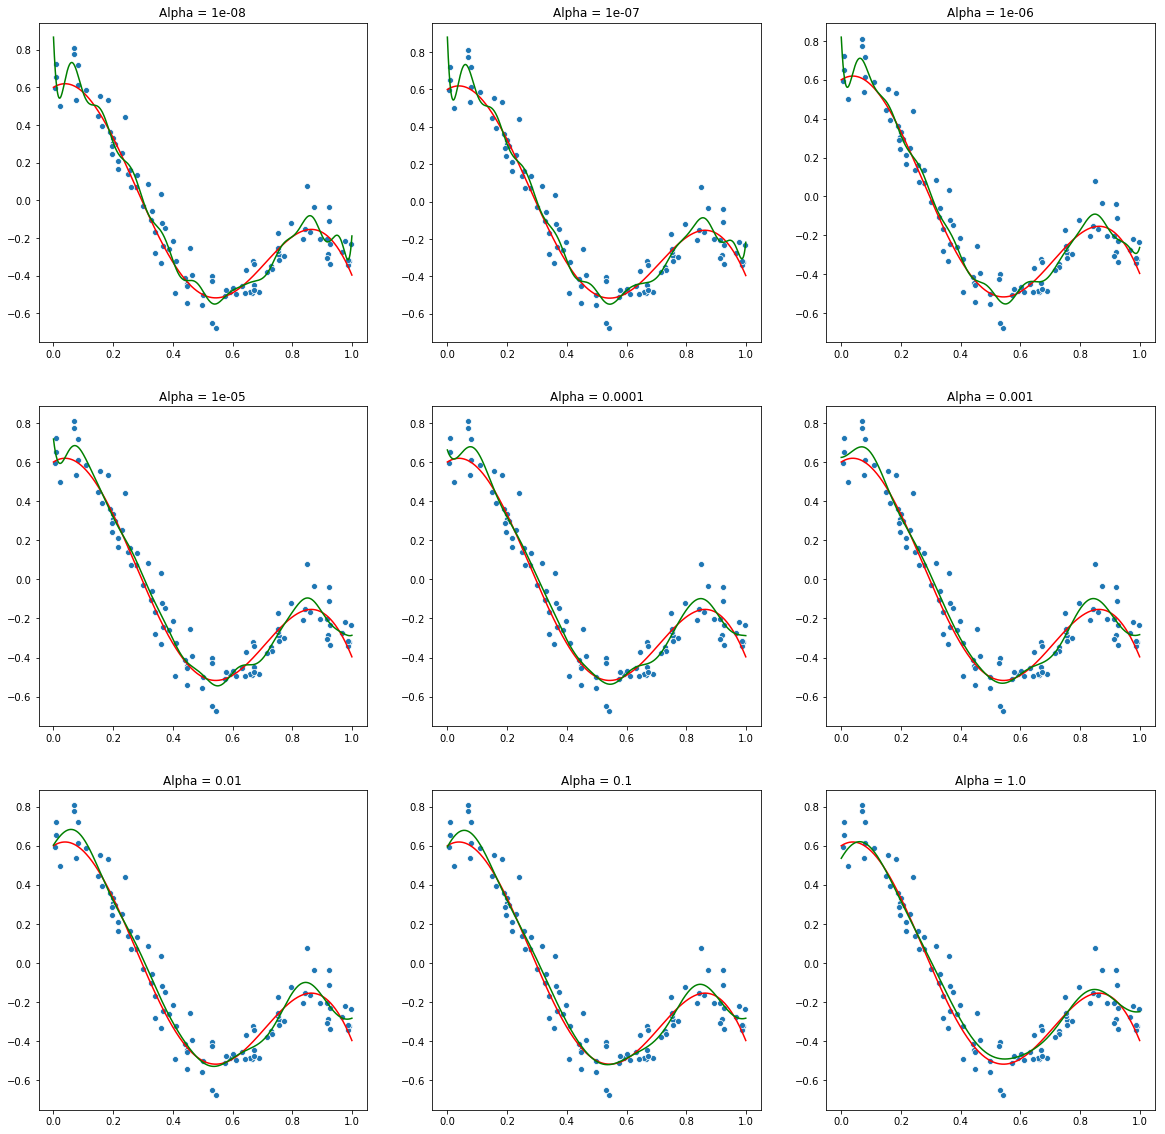

In [88]:
#using rbf kernel for ridge regression regularization
#hyperparameters are gamma i.e. denominator of rbf and alpha ie regularization, but here gamma is fixed and alpha 
#is varied

#import kernel ridge regressor
from sklearn.kernel_ridge import KernelRidge

#assign alpha range
alphas = 1/10**np.arange(0,9,1)

fig, ax = plt.subplots(3,3,figsize=(20,20))
ax = ax.flatten()
ax_count = 8
for a in alphas:
    krr = KernelRidge(alpha = a, kernel = "rbf", gamma = 50)
    krr.fit(x.reshape(-1,1), y)
    pred = krr.predict(x_exact.reshape(-1,1))
    sns.scatterplot(x, y, ax=ax[ax_count])
    sns.lineplot(x_exact, y_exact, ax=ax[ax_count], color = 'r')
    sns.lineplot(x_exact, pred, ax=ax[ax_count], color = 'g')
    ax[ax_count].set(title = 'Alpha = {}'.format(a))
    ax_count-=1

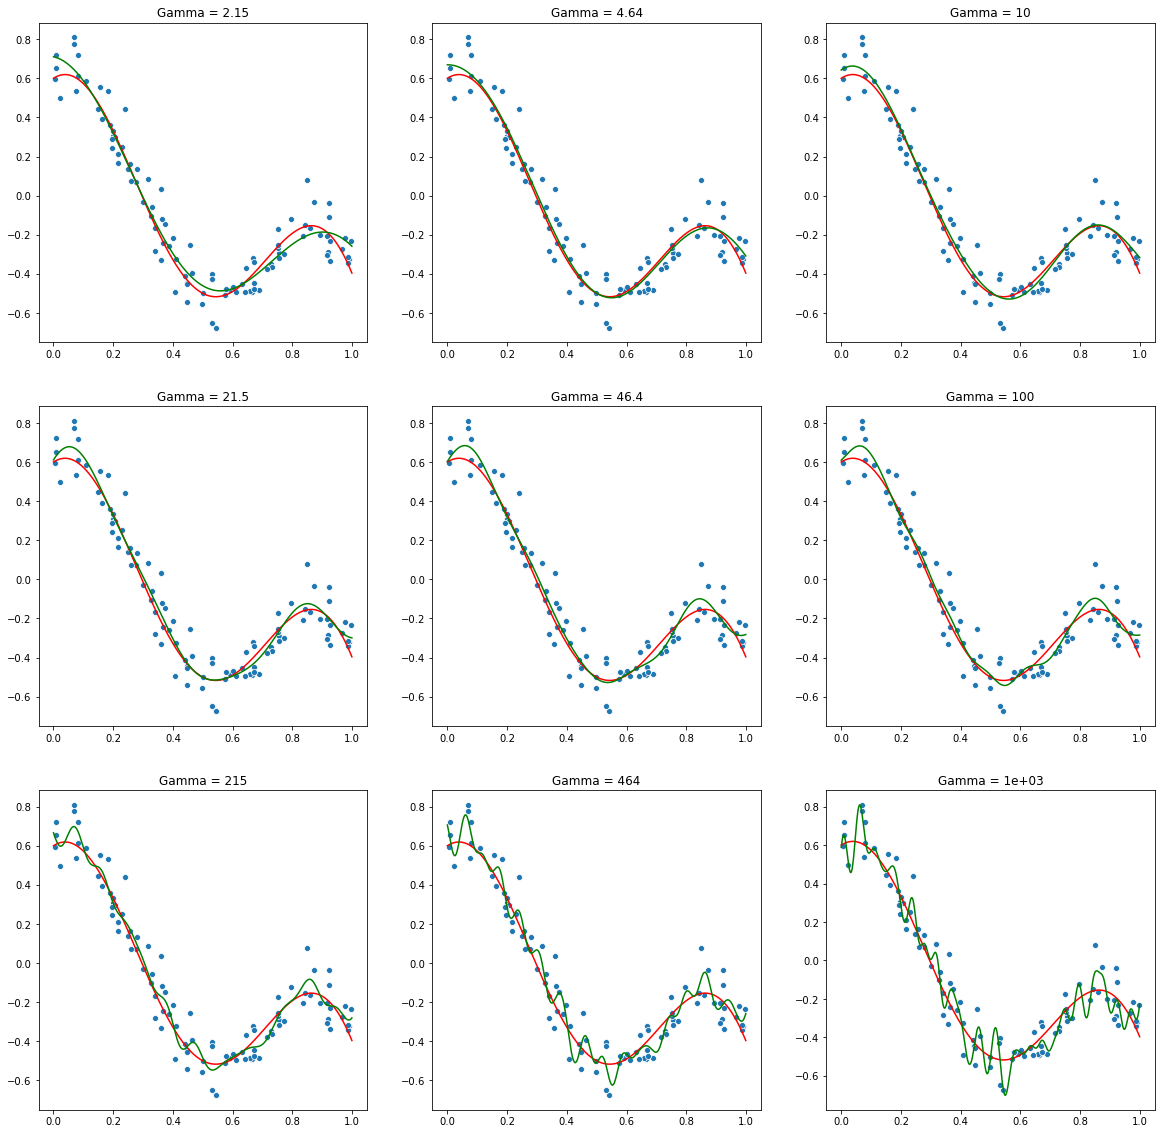

In [89]:
#now to hold alpha fixed and vary gamma ie inverse bandwith

#assign gamma range
gammas = 10**(np.arange(1,10,1)/3)

fig, ax = plt.subplots(3,3,figsize=(20,20))
ax = ax.flatten()
ax_count = 0
for g in gammas:
    krr = KernelRidge(alpha = 0.01, kernel = 'rbf', gamma = g)
    krr.fit(x.reshape(-1,1), y)
    pred = krr.predict(x_exact.reshape(-1,1))
    sns.scatterplot(x, y, ax=ax[ax_count])
    sns.lineplot(x_exact, y_exact, ax=ax[ax_count], color = 'r')
    sns.lineplot(x_exact, pred, ax=ax[ax_count], color = 'g')
    ax[ax_count].set(title = 'Gamma = {0:.3g}'.format(g))
    ax_count+=1

In [90]:
#Now use cross validation to run with varying both gamma and alpha

#import grid search cv
from sklearn.model_selection import GridSearchCV

#model and parameter dictionary
krr = KernelRidge(kernel = 'rbf')
params = {'alpha': alphas, 'gamma': gammas}

#grid search with 10 fold cv on mean squared error
krr_tuned = GridSearchCV(krr, param_grid = params, cv = 10, scoring = 'neg_mean_squared_error')
krr_tuned.fit(x.reshape(-1,1), y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05,   1.00000e-06,   1.00000e-07,
         1.00000e-08]), 'gamma': array([    2.15443,     4.64159,    10.     ,    21.54435,    46.41589,
         100.     ,   215.44347,   464.15888,  1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

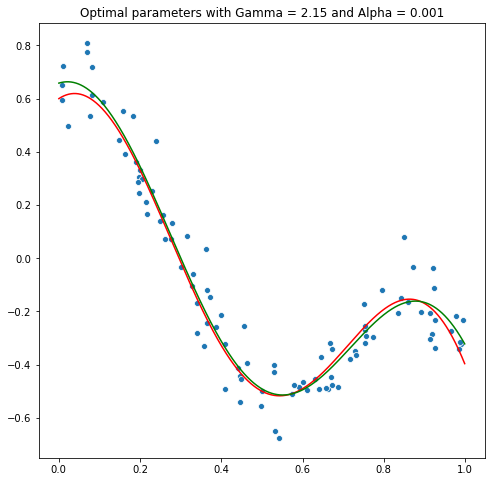

In [92]:
#apply to test data
pred = krr_tuned.predict(x_exact.reshape(-1,1))

#plot and it overfit and i dont know why
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.scatterplot(x, y)
sns.lineplot(x_exact, y_exact, color = 'r')
sns.lineplot(x_exact, pred, color = 'g')
ax.set(title = 
       'Optimal parameters with Gamma = {0:.3g} and Alpha = {1}'.format(krr_tuned.best_params_.get('gamma'), 
                                                                        krr_tuned.best_params_.get('alpha')))
plt.show()